<img src="HDC_logo.png" width=50%>





Haaretz.com is the English version of Haaretz, Israel's 100 year-old newspaper.
The site airs ~50 articles a day and serves 450K Pages to 250K daily users.

The objective of this project is to create the preliminary infrastructure for a not-so-far-future live product, that will allow the site to deliver personalized article recommendations using the power of NLP Models.

In [ ]:
# General
# -------
import re
import json
import numpy as np
import pandas as pd
import logging
from scipy.spatial import distance
from collections import Counter
from smart_open import smart_open
from random import sample

# NLP stuff
# ---------

import gensim
from gensim import corpora, models, utils
from gensim.models import LdaModel, LdaMulticore
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess, lemmatize
from gensim.test.utils import common_texts

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
nltk.download('stopwords')  # run once
stop_words = stopwords.words('english')

# Styling
# -------
from pprint import pprint
import matplotlib.pyplot as plt

C:\Users\innbal.menashri\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\innbal.menashri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# The Articles
The first step was creating a dataset of the articles' IDs and content

In [ ]:
# Create empty DF
articles = pd.DataFrame(columns = ['article_id', 'title', 'body', 'publish_time', 'topic', 'doc2vec'])
articles.set_index('article_id', inplace=True)

In [ ]:
# Load data from files
suffixes = ['A', 'B', 'C', 'D', 'E', 'F']
    
for suffix in suffixes:
    file_name = 'ArticlesDec923'+suffix+'.json'
    with open(file_name, encoding='utf-8') as f:
        json_articles = json.load(f)

    for doc in json_articles['response']['docs']:
        article_id = str(doc['contentId'])
        title = doc['sortTitle']
        publish_time = doc['publishingDate']
        body = doc['text'][0]

        articles.loc[article_id] = [title, body, publish_time, np.nan, np.nan]

In [ ]:
num_of_articles = articles.title.count()
num_of_articles

2143

In [ ]:
articles.head()

,title,body,publish_time,topic,doc2vec
article_id,,,,,
1.4777188,Grounds for disbelief,<p>Prof. Israel Finkelstein sees no contradict...,2003-05-07T21:00:00Z,NaN,NaN
1.4776064,Underworld boss held on suspicion of ordering ...,"<p>Ze'ev Rosenstein, the Tel Aviv police's for...",2003-12-01T22:00:00Z,NaN,NaN
1.4779264,News in Brief,<p>Ambulance driver held in rape probe </p> \...,2003-12-04T22:00:00Z,NaN,NaN
1.5318044,Religious Zionist leader Rabbi Moti Elon convi...,<p>The Jerusalem Magistrate's Court on Tuesday...,2013-08-07T07:21:00.723Z,NaN,NaN
1.5180977,Gur Hasidim and sexual separation,"<p>One day in 1976, a student entered our clas...",2012-02-03T07:35:00.743Z,NaN,NaN


I had to clean the data...

In [ ]:
# Remove HTML tags
bad_patterns = [r'<p>', r'</p>', r'\n', r'&quot;', r'&nbsp;', r'■']
counter = 0

for indx in articles.index:
    for bad_pattern in bad_patterns:
        if re.search(bad_pattern, articles.loc[indx].body) is not None:
            articles.loc[indx].body = articles.loc[indx].body.replace(bad_pattern, '')
            counter = counter +1

print('{} problems fixed'.format(counter))

8970 problems fixed


In [ ]:
articles.head()

,title,body,publish_time,topic,doc2vec
article_id,,,,,
1.4777188,Grounds for disbelief,Prof. Israel Finkelstein sees no contradiction...,2003-05-07T21:00:00Z,NaN,NaN
1.4776064,Underworld boss held on suspicion of ordering ...,"Ze'ev Rosenstein, the Tel Aviv police's foremo...",2003-12-01T22:00:00Z,NaN,NaN
1.4779264,News in Brief,Ambulance driver held in rape probe \n A 45-...,2003-12-04T22:00:00Z,NaN,NaN
1.5318044,Religious Zionist leader Rabbi Moti Elon convi...,The Jerusalem Magistrate's Court on Tuesday co...,2013-08-07T07:21:00.723Z,NaN,NaN
1.5180977,Gur Hasidim and sexual separation,"One day in 1976, a student entered our classro...",2012-02-03T07:35:00.743Z,NaN,NaN


## Using NLP Models to Create Measurable Features

In [ ]:
all_article_bodies = {}         # A dict holding the body and title (value) for each article ID (key)
for indx in articles.index:
    all_article_bodies[indx] = [articles.loc[indx].body, articles.loc[indx].title]

### Tokenizing the text

In [ ]:
import string
punc = list(string.punctuation)
more_puncs = ['’', '”', '“', '–']
punc.append([more_punc for more_punc in more_puncs])

body_words_lists = {}          # A dict holding a LIST of tokens (value) for each article ID (key)
body_words_sets = {}           # A dict holding a SET of tokens (value) for each article ID (key)
document_frequency = Counter()

for article in all_article_bodies:
    good_tokens = []
    article_tokens = word_tokenize(all_article_bodies[article][0])
    title_tokens = 5 * word_tokenize(all_article_bodies[article][1])   # Extra strength to title words
    article_tokens = article_tokens + title_tokens
    for token in article_tokens:
        if ((token not in punc) and (token.lower() not in STOPWORDS)): # Check punctuation as separate string
            good_tokens.append(token.lower())
    unique_tokens = set(good_tokens)
    document_frequency.update(unique_tokens)
    body_words_lists[article] = good_tokens
    body_words_sets[article] = unique_tokens

In [ ]:
body_words_lists['1.5180977']

['day',
 '1976',
 'student',
 'entered',
 'classroom',
 'beit',
 'yaakov',
 'seminar',
 'tel',
 'aviv',
 'weeping',
 'passionately',
 'informed',
 'revered',
 'gerer',
 'rebbe',
 'so-called',
 'beis',
 'yisroel',
 'rabbi',
 'israel',
 'alter',
 'died',
 'classes',
 'seminar',
 'affiliated',
 'gur',
 'hasidic',
 'sect',
 'suspended',
 'immediately',
 'including',
 'girls',
 'lithuanian',
 'community',
 'ultra-orthodox',
 'jews',
 'historically',
 'opposed',
 'hasidism',
 'belonged',
 'bawled',
 'eyes',
 'beis',
 'yisroel',
 'ruled',
 'gur',
 'hasidism',
 '1948',
 '1976',
 'dominant',
 'leader',
 'revolutionized',
 'sect',
 'days',
 'won',
 'admiration',
 'ultra-orthodox',
 'world',
 'steeped',
 'secrecy',
 'came',
 'relations',
 'men',
 'women',
 'time',
 'emerged',
 'unusual',
 'gur',
 'customs',
 'realm',
 'tied',
 'concept',
 'kedusha',
 'sanctity',
 'stems',
 'unique',
 'attitude',
 'sexuality',
 'conjugal',
 'relations',
 'sect',
 'understanding',
 'topic',
 'result',
 'research',


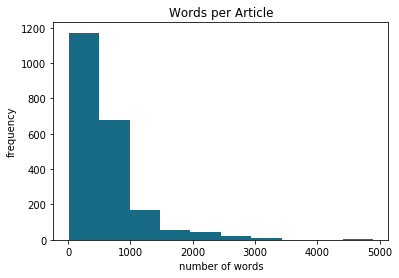

In [ ]:
values = [len(val) for val in body_words_lists.values()]

plt.hist(values, color = '#186B85')
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Words per Article')

plt.show()

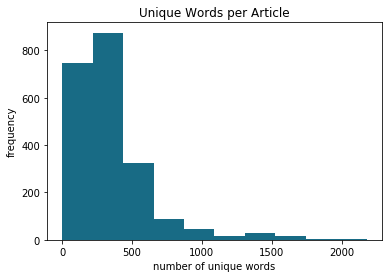

In [ ]:
values = [len(val) for val in body_words_sets.values()]

plt.hist(values, color='#186B85')
plt.xlabel('number of unique words')
plt.ylabel('frequency')
plt.title('Unique Words per Article')

plt.show()

### Creating a Dictionary and a Bag of Words

In [ ]:
# Create the Corpus
HDC_dictionary = corpora.Dictionary()
HDC_corpus = []

HDC_corpus = [HDC_dictionary.doc2bow(doc, allow_update=True) for doc in body_words_lists.values()]

set_of_total_words = set()
for l in HDC_corpus:
    for w in l:
        set_of_total_words.add(w)

print('the HDC corpus consists of: {} differnet words in {} articles.'\
      .format(len(set_of_total_words), HDC_dictionary.num_docs))

the HDC corpus consists of: 108370 differnet words in 2143 articles.


In [ ]:
# Check that the set of words was created
words_to_print = sample(set_of_total_words, 10)
print('Here\'s a sample of the words in the corpus:')
print()
pprint(words_to_print)

Here's a sample of the words in the corpus:

[(5033, 2),
 (57106, 1),
 (8647, 1),
 (45339, 1),
 (63818, 3),
 (2523, 1),
 (178, 1),
 (32739, 2),
 (32173, 1),
 (59889, 1)]


## Finding Topics - LDA Model

In [ ]:
# Initiate the LDA model to create topics
num_of_topics = 7
lda = LdaModel(HDC_corpus, num_topics=num_of_topics, id2word = HDC_dictionary, passes=70)

In [ ]:
HDC_topics = {}
topic_regex = r'"\w*"'
counter = 0

for idx, topic in lda.print_topics(-1):
    HDC_topics[idx] = []
    topic_tmp = topic
    
    while re.search(topic_regex, topic_tmp) is not None:
        topic_string = re.search(topic_regex, topic_tmp).group()
        topic_string_sliced = topic_string[1:-1]
        HDC_topics[idx].append(topic_string_sliced)
        topic_tmp = topic_tmp.replace(topic_string, '')
        counter = counter +1
        
for i in range(num_of_topics):
    print('Topic', i+1, ':', HDC_topics[i])

Topic 1 : ['s', 't', 'israel', 'says', 'years', 'people']
Topic 2 : ['s', 'israel', 'jewish', 'trump', 'jews', 'said']
Topic 3 : ['saudi', 's', 'jewish', 'says', 'jews', 'said', 'prince']
Topic 4 : ['syria', 'trump', 's', 'said', 'israel', 'president', 'russia']
Topic 5 : ['palestinian', 'said', 'soldiers', 'attack', 'israel', 'west', 'israeli', 's']
Topic 6 : ['israel', 's', 'netanyahu', 'minister', 'said', 'israeli', 'law', 'government']
Topic 7 : ['s', 'israel', 'said', 'gaza', 'israeli', 'children', 'ramon']


#### Looking for frequent words to remove

In [ ]:
for word, freq in document_frequency.most_common(20):
    print('{}\t{}'.format(word, freq))

’	1761
s	1719
israel	1666
”	1542
“	1536
said	1515
israeli	1279
's	1265
people	1263
years	1239
time	1221
t	1210
new	1169
–	1060
like	1032
state	977
minister	947
world	924
government	924
year	922


In [ ]:
# Create a list of very frequent words to remove
very_frequent = 0.4 * num_of_articles
frequent_words = [word for word in document_frequency if document_frequency[word] > very_frequent]
general_words = ['israel', 'israeli', 'siad', 'says', 'president', 'jewish']

words_to_remove = set(frequent_words + general_words)
print('There are {} very frequent words and they are:'.format(len(frequent_words)))
pprint(frequent_words)

There are 21 very frequent words and they are:
['year',
 'years',
 "'s",
 'said',
 'like',
 'new',
 'world',
 'israel',
 'time',
 'people',
 'state',
 'government',
 'jewish',
 'minister',
 'israeli',
 '–',
 's',
 't',
 '“',
 '”',
 '’']


In [ ]:
# Remove frequent words from article texts
body_words_lists_after = {}
body_words_sets_after = {}
document_frequency_after = Counter()

for article in all_article_bodies:
    good_tokens = [token for token in body_words_lists[article] if token not in words_to_remove]
           
    unique_tokens = set(good_tokens)
    document_frequency_after.update(unique_tokens)
    body_words_lists_after[article] = good_tokens
    body_words_sets_after[article] = unique_tokens

In [ ]:
# Create the corpus again
HDC_dictionary_after = corpora.Dictionary()
HDC_corpus_after = [HDC_dictionary_after.doc2bow(doc, allow_update=True) for doc in body_words_lists_after.values()]

set_of_total_words_after = set()

for l in HDC_corpus_after:
    for w in l:
        set_of_total_words_after.add(w)

print('the HDC corpus consists of: {} differnet words in {} articles.'\
      .format(len(set_of_total_words_after), HDC_dictionary_after.num_docs))

the HDC corpus consists of: 107554 differnet words in 2143 articles.


In [ ]:
# Re-run the model
lda = LdaModel(HDC_corpus_after, num_topics=num_of_topics, id2word = HDC_dictionary_after, passes=70)

In [ ]:
# Create the final Topics Dict
HDC_topics = {}
topic_regex = r'"\w*"'
counter = 0

for idx, topic in lda.print_topics(-1):
    HDC_topics[idx] = {}
    HDC_topics[idx]['topic_words'] = []
    HDC_topics[idx]['article_vectors'] = []
    HDC_topics[idx]['mean_vector'] = []
    topic_tmp = topic
    
    while re.search(topic_regex, topic_tmp) is not None:
        topic_string = re.search(topic_regex, topic_tmp).group()
        topic_string_sliced = topic_string[1:-1]
        HDC_topics[idx]['topic_words'].append(topic_string_sliced)
        topic_tmp = topic_tmp.replace(topic_string, '')
        counter += 1
        
for i in range(num_of_topics):
    print('Topic', i+1, ':', HDC_topics[i]['topic_words'])

Topic 1 : ['netanyahu', 'palestinian', 'west', 'bank', 'gaza', 'law', 'palestinians', 'security', 'attack', 'hezbollah']
Topic 2 : ['trump', 'syria', 'russia', 'american', 'withdrawal', 'turkey', 'iran', 'troops', 'forces']
Topic 3 : ['saudi', 'trump', 'prince', 'arabia', 'crown', 'iran', 'turns', 'house']
Topic 4 : ['jews', 'women', 'arab', 'country', 'political', 'way', 'community', 'war', 'know']
Topic 5 : ['jews', 'jerusalem', 'percent', 'site', 'torah', 'students', 'study', 'city']
Topic 6 : ['million', 'company', 'shekels', 'companies', 'airport', 'technology', 'price', 'housing', 'tel', 'aviv']
Topic 7 : ['ramon', 'rona', 'children', 'death', 'rabbi', 'family', 'read', 'sea', 'conservative', 'son']


### Assiging Topics to Articles
Now it is time to assign a topic for each article and add it as a new feature: topic

In [ ]:
# Assign a topic to each article
for article in all_article_bodies:
    counter_dict = {}
    for i in range(num_of_topics):
        counter_dict[i] = 0
        for word in body_words_lists[article]:
            if word in HDC_topics[i]['topic_words']:
                counter_dict[i] = counter_dict[i]+1
    max_topic = max(counter_dict.values())
     
    for topic, topic_count in counter_dict.items():
        if topic_count == max_topic:
            best_topic = topic

# Add best topic to the articles dataset    
    articles.loc[article].topic = best_topic

## Enter Doc2Vec
Using the Doc2Vec model, I calculated a vector for each article's content

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in all_article_bodies.items()]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1, workers=4)

# # Persist the model to disk:
# from gensim.test.utils import get_tmpfile
# fname = get_tmpfile("HDC_doc2vec")
# model.save(fname)
# model = Doc2Vec.load(fname)

# # Reduce memory once the model is trained
# model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
# Return a vector reoresenting each article
for article in all_article_bodies:
    article_vector = model.infer_vector([all_article_bodies[article][0], 'response'])
    articles.loc[article].doc2vec = article_vector

# Create a list of vectors for each topic    
    HDC_topics[articles.loc[article].topic]['article_vectors'].append(article_vector)

In [ ]:
articles.head()

,title,body,publish_time,topic,doc2vec
article_id,,,,,
1.4777188,Grounds for disbelief,Prof. Israel Finkelstein sees no contradiction...,2003-05-07T21:00:00Z,6,"[-0.0453819, -0.038614783, 0.030050514, 0.0271..."
1.4776064,Underworld boss held on suspicion of ordering ...,"Ze'ev Rosenstein, the Tel Aviv police's foremo...",2003-12-01T22:00:00Z,6,"[-0.015582361, -0.046023287, 0.004102045, 0.03..."
1.4779264,News in Brief,Ambulance driver held in rape probe \n A 45-...,2003-12-04T22:00:00Z,0,"[-0.012029479, -0.012647628, -0.031939577, -0...."
1.5318044,Religious Zionist leader Rabbi Moti Elon convi...,The Jerusalem Magistrate's Court on Tuesday co...,2013-08-07T07:21:00.723Z,6,"[-0.01221874, 0.010205295, 0.02911482, 0.01936..."
1.5180977,Gur Hasidim and sexual separation,"One day in 1976, a student entered our classro...",2012-02-03T07:35:00.743Z,2,"[-0.026743947, 0.009536785, 0.042030953, -0.00..."


And then calculated a vector that represents the mean for each topic

In [ ]:
for t in range(num_of_topics):
    HDC_topics[t]['mean_vector'] = np.mean(HDC_topics[t]['article_vectors'], axis=0) # * 1000
    print('Topic', t+1, ':', HDC_topics[t]['mean_vector'])

Topic 1 : [ 2.12120195e-03  3.90539004e-04  1.67150795e-03 -2.77742068e-03
 -1.94070453e-03  1.20991435e-05 -1.36112352e-03 -8.50021024e-04
 -1.05337554e-03  2.82857101e-03]
Topic 2 : [-7.5874982e-06  4.3561024e-04 -1.0016265e-03  5.1557750e-04
  1.2732974e-03  1.6002066e-03  6.0927868e-04  7.9286285e-05
  5.2382366e-05 -1.8128619e-04]
Topic 3 : [ 0.00181399 -0.00033035  0.00085002 -0.00102963 -0.00111778  0.00060197
 -0.00224972  0.00022367  0.00375784 -0.003058  ]
Topic 4 : [-0.00380804 -0.00224597 -0.00362915  0.0027896  -0.00063255 -0.00112517
  0.00072362 -0.00015156  0.00090633 -0.00023748]
Topic 5 : [-7.5531140e-04  7.4548479e-05 -2.1523105e-03 -9.4082486e-04
 -9.1305381e-04 -5.9787650e-04 -2.1306959e-03  1.9247617e-03
 -1.1256667e-05  2.9598838e-03]
Topic 6 : [-0.00112152 -0.00104851 -0.00045963  0.00162522 -0.00404494  0.00464059
  0.00193863  0.00177782  0.00024976  0.00200949]
Topic 7 : [-0.00373453 -0.00046061  0.0012745   0.00178993  0.00272452  0.00204306
 -0.00288734 -0.

# Requests
The second step was creating a DF of the articles that were read by users

In [ ]:
requests = pd.DataFrame(columns = ['user', 'platform', 'request_time', 'article_id', 'author', 'section'])

In [ ]:
suffixes = ['A', 'B', 'C', 'D', 'E']
    
for suffix in suffixes:
    file_name = 'RequestsDec923'+suffix+'.txt'
    new_requests = pd.read_csv(file_name, index_col=False, delimiter="\t", converters={'user':str, 'article_id':str})
    requests = requests.append(new_requests, ignore_index=True, sort=False)

In [ ]:
print(requests.count())
print()
print(requests['user'].nunique(), 'users read', requests['article_id'].nunique(), 'articles')

user            435285
platform        435285
request_time    435285
article_id      435285
author           49762
section          61945
dtype: int64

8267 users read 1587 articles


In [ ]:
requests['user'].nunique()

8267

In [ ]:
unique_articles = requests['article_id'].nunique()
unique_articles

1587

In [ ]:
requests.head(7)

,user,platform,request_time,article_id,author,section
0,6941236156,Web Mobile Phone,09-12-2018 00:00:05,1.6723181,NaN,NaN
1,7859361480,App Mobile Phone,09-12-2018 00:00:17,1.6723109,Roy Arad,israel-news
2,7458252835,Web Mobile Phone,09-12-2018 00:00:30,1.6724306,NaN,NaN
3,9037811937,Web Mobile Phone,09-12-2018 00:01:16,1.6723109,NaN,NaN
4,9037811937,Web Mobile Phone,09-12-2018 00:01:28,1.6723109,NaN,NaN
5,7189902052,Web Mobile Phone,09-12-2018 00:02:01,1.6717978,NaN,NaN
6,7372725793,Web Mobile Phone,09-12-2018 00:02:02,1.6723109,NaN,NaN


I fixed data collection errors...

In [ ]:
# Fix mistakes in data

requests.drop(['author', 'section'], axis=1, inplace=True)

bad_pattern = r'-'
good_pattern = r'1\.\d{4,8}'
counter = 0

for indx in requests.index:
    if re.search(bad_pattern, requests.loc[indx].article_id) is not None:
        good_match = re.compile(good_pattern).search(requests.loc[indx].article_id).group()
        requests.loc[indx].article_id = good_match
        counter = counter +1

print('{} problems fixed'.format(counter))

2914 problems fixed


In [ ]:
requests.head(7)

,user,platform,request_time,article_id
0,6941236156,Web Mobile Phone,09-12-2018 00:00:05,1.6723181
1,7859361480,App Mobile Phone,09-12-2018 00:00:17,1.6723109
2,7458252835,Web Mobile Phone,09-12-2018 00:00:30,1.6724306
3,9037811937,Web Mobile Phone,09-12-2018 00:01:16,1.6723109
4,9037811937,Web Mobile Phone,09-12-2018 00:01:28,1.6723109
5,7189902052,Web Mobile Phone,09-12-2018 00:02:01,1.6717978
6,7372725793,Web Mobile Phone,09-12-2018 00:02:02,1.6723109


I then began reducing to create only one instance for each combination of user + article + platform

In [ ]:
non_dup_requests = requests.drop_duplicates(subset=['article_id', 'user', 'platform'], keep='first')
print(non_dup_requests.count())
print()
print(non_dup_requests['user'].nunique(), 'users read', non_dup_requests['article_id'].nunique(), 'articles')

user            267264
platform        267264
request_time    267264
article_id      267264
dtype: int64

8267 users read 1301 articles


### Popular Articles
I began looking for the most popular articles - these are the articles I will recommend to other users

In [ ]:
users_per_article = non_dup_requests.groupby('article_id')['user'].count()

print('min_users_per_article:', users_per_article.min())
print('max_users_per_article:', users_per_article.max())
print('median_users_per_article:', users_per_article.median())

min_users_per_article: 1
max_users_per_article: 3384
median_users_per_article: 6.0


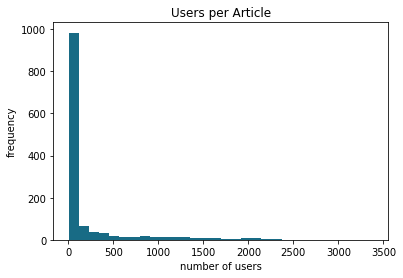

In [ ]:
values = users_per_article.values

plt.hist(values, bins=30 , color = '#186B85')
plt.xlabel('number of users')
plt.ylabel('frequency')
plt.title('Users per Article')

plt.show()

In [ ]:
# Crop the most popular articles and sort them by popularity
popular_articles_series = users_per_article.where(lambda x : x > 30).dropna()\
                          .sort_values(ascending=False, kind='quicksort', inplace=False)

print('The number of articles came from {} down to {} interesting ones.'\
      .format(unique_articles, len(popular_articles_series)))

The number of articles came from 1587 down to 495 interesting ones.


So I saved a list of the articles I want to recommend

In [ ]:
articles_to_recommend = list(popular_articles_series.index)
articles_to_recommend[:10]

['1.6746868',
 '1.6726228',
 '1.6744552',
 '1.6723443',
 '1.6743207',
 '1.6744621',
 '1.6739756',
 '1.6758959',
 '1.6729331',
 '1.6743889']

### Users
I continued to the investigation of the users

In [ ]:
articles_per_user = non_dup_requests.groupby('user')['article_id'].count()

print('min_articles_per_user:', articles_per_user.min())
print('max_articles_per_user:', articles_per_user.max())
print('median_articles_per_user:', articles_per_user.median())

min_articles_per_user: 1
max_articles_per_user: 467
median_articles_per_user: 16.0


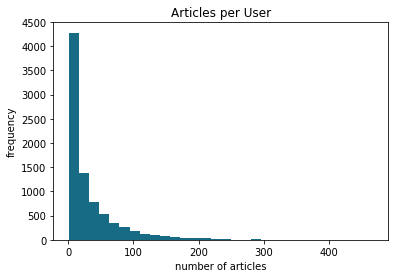

In [ ]:
values = articles_per_user.values

plt.hist(values, bins=30 , color = '#186B85')
plt.xlabel('number of articles')
plt.ylabel('frequency')
plt.title('Articles per User')

plt.show()

I created a new DF to store the preferences of each user.
The number of columns is dynamicaly specified by the number of topics.

In [ ]:
count_name = '_article_count'
mean_name = '_mean_article_vector'

list1 = ['topic_'+str(t)+mean_name for t in range(num_of_topics)]
list2 = ['topic_'+str(t)+count_name for t in range(num_of_topics)]
list3 = ['user', 'total'+count_name, 'total'+mean_name]
joint_list = list3 + list2 + list1

user_preferences = pd.DataFrame(columns = joint_list)
user_preferences.set_index('user', inplace=True)

user_preferences.count()

total_article_count            0
total_mean_article_vector      0
topic_0_article_count          0
topic_1_article_count          0
topic_2_article_count          0
topic_3_article_count          0
topic_4_article_count          0
topic_5_article_count          0
topic_6_article_count          0
topic_0_mean_article_vector    0
topic_1_mean_article_vector    0
topic_2_mean_article_vector    0
topic_3_mean_article_vector    0
topic_4_mean_article_vector    0
topic_5_mean_article_vector    0
topic_6_mean_article_vector    0
dtype: int64

In [ ]:
def get_user_preferences(user, num_of_topics):
    to_return = []
    articles_read = get_articles_read(user)
    for article in articles_read:
        if articles.index.contains(article) == False:
            articles_read.remove(article)
    if len(articles_read) == 0:
        return
    list_to_arrays = pd.Series([articles.loc[article].doc2vec for article in articles_read])
    to_return.append(len(list_to_arrays))
    to_return.append(get_mean_article_vector(list_to_arrays))
   
    for topic in range(num_of_topics):
        list_to_arrays = []
        list_to_arrays = pd.Series([articles.loc[article].doc2vec\
                         for article in articles_read if articles.loc[article].topic == topic])
        to_return.append(len(list_to_arrays))
    
    for topic in range(num_of_topics):
        list_to_arrays = []
        list_to_arrays = pd.Series([articles.loc[article].doc2vec\
                         for article in articles_read if articles.loc[article].topic == topic])
        if len(list_to_arrays) != 0:
            to_return.append(get_mean_article_vector(list_to_arrays))
        else:
            to_return.append(0)
    
    return to_return

def get_articles_read(user):
    articles_read = list(requests.article_id[requests.user == user].values)
    return articles_read

def get_mean_article_vector(list_to_arrays):
    mean_article_vector = list_to_arrays.mean(axis=0)
    return mean_article_vector

In [ ]:
for user in requests['user'].unique():
    if len(get_articles_read(user)) != 0:
        user_preferences.loc[user] = get_user_preferences(user, num_of_topics)

In [ ]:
# ##
# user_preferences.loc['7328651521'] = get_user_preferences('7328651521', num_of_topics)
# ##

# Implementation

Now, let's see what the best article recommendation we can find for user 7328651521 is:

In [ ]:
pprint(user_preferences.loc['7328651521'])

total_article_count                                                           37
total_mean_article_vector      [0.006770647, 0.0055826264, -0.004129346, 0.00...
topic_0_article_count                                                          6
topic_1_article_count                                                         10
topic_2_article_count                                                          3
topic_3_article_count                                                          8
topic_4_article_count                                                          7
topic_5_article_count                                                          2
topic_6_article_count                                                          1
topic_0_mean_article_vector    [0.026372507, -0.011296759, -0.011252238, 5.53...
topic_1_mean_article_vector    [0.020113515, 0.0062921895, -0.010298379, 0.01...
topic_2_mean_article_vector    [0.041798454, 0.045146886, 0.017904587, 0.0394...
topic_3_mean_article_vector 

In [ ]:
def best_articles(user, number_of_articles=1):
    rec_articles_not_read = [rec_article for rec_article in articles_to_recommend[:20]\
                             if ((rec_article not in get_articles_read(user)) and (rec_article in articles.index))]
    
    rec_article_details = pd.DataFrame(columns = ['article_id', 'title', 'doc2vec', 'distance_from_user'])
    rec_article_details.set_index('article_id', inplace=True)
    for rec_article in rec_articles_not_read:
        title = articles.loc[rec_article].title
        doc2vec = articles.loc[rec_article].doc2vec
        distance_from_user = distance.euclidean(doc2vec, user_preferences.loc[user].total_mean_article_vector)
        
        rec_article_details.loc[rec_article] = [title, doc2vec, distance_from_user]

    top_rec_articles = rec_article_details.nlargest(number_of_articles, ['distance_from_user'])
    top_rec_articles.drop(['doc2vec', 'distance_from_user'], axis=1, inplace=True)
    
    return top_rec_articles 

In [ ]:
best_articles('7328651521', number_of_articles=5)

,title
article_id,
1.6729331,"Kidnapped, escaped, and survived to tell the t..."
1.6727455,Ocasio-Cortez reveals Jewish heritage at Hanuk...
1.6744552,"From Lebanon to Iraq: Iran’s new, hybrid threa..."
1.6745671,Australia: We recognize West Jerusalem as Isra...
1.6740071,Why we shouldn't be surprised by Ocasio-Cortez...
